# Data Preparation

Effective data preparation is foundational to successful machine learning models. This notebook guides you through preparing the RSNA Pneumonia Detection dataset for training, including data exploration, stratified splitting, visualization, and integration with Azure Machine Learning for streamlined model development.

## What you will do:

* Load and explore the dataset from the CSV file
* Create stratified splits for training, validation, and testing
* Visualize data distributions and image samples, including bounding boxes for positive cases
* Register the dataset and related data assets with Azure Machine Learning

Data preparation is critical for ensuring your models train on high-quality, properly organized data. Through this notebook, you'll learn essential techniques for processing medical imaging data and setting up a robust machine learning pipeline using Azure ML's data management capabilities.

## Setup Pre-requisites

Before starting, ensure you have the following ready:

* Download the RSNA Pneumonia Detection dataset. It should be organized as follows:
  - CSV file: `stage_2_train_labels.csv`
  - DICOM images in the `stage_2_train_images` folder.
* Make sure you have run `pip install -r requirements.txt` from the root directory.
* Configure and authenticate with your Azure ML Workspace.

The RSNA Pneumonia Detection dataset contains chest X-ray images with annotations indicating whether pneumonia is present and, if so, where in the image it appears. By properly preparing this dataset, you'll ensure your model can effectively learn the patterns that distinguish pneumonia cases from normal cases.

## Download Data

Go to the provided links to download the data. You can download directly to an AzureML compute with:
```sh
wget -O /home/azureuser/data/rsna-pneumonia-detection-challenge.zip '<url to zip>'
unzip /home/azureuser/data/rsna-pneumonia-detection-challenge.zip -d /home/azureuser/data/rsna-pneumonia-detection-challenge
ls -l /home/azureuser/data/rsna-pneumonia-detection-challenge
```

Once downloaded, we'll explore the dataset structure, create appropriate splits for model development, and register it with Azure ML to enable seamless access during training and evaluation phases.

## Load and Preview CSV Dataset

This section begins our data preparation pipeline by loading the RSNA Pneumonia Detection Challenge dataset from the CSV file and performing initial examination. The CSV file contains critical information about each image, including patient IDs, class labels (pneumonia/normal), and bounding box coordinates for positive pneumonia cases.

Understanding this tabular data is essential before proceeding with image processing, as it provides the ground truth annotations we'll need for model training. A thorough inspection of the dataset structure will help identify any potential issues such as missing values, class imbalance, or unexpected patterns.

Steps:
- Define the dataset directory path and locate the primary CSV file (`stage_2_train_labels.csv`)
- Import the data into a pandas DataFrame for efficient manipulation and analysis
- Display a random sample of rows to verify the data structure and contents
- Examine key fields including `patientId`, `class`, and bounding box coordinates (`x`, `y`, `width`, `height`)
- Confirm the data types and verify that no critical information is missing

This initial exploration provides the foundation for subsequent data processing steps and helps determine appropriate strategies for data splitting and augmentation.

In [1]:
import os
import pandas as pd

# Define the local directory holding the dataset
dataset_path = '/home/azureuser/data/rsna-pneumonia-detection-challenge/'

csv_file = os.path.join(dataset_path, "stage_2_train_labels.csv")

df = pd.read_csv(csv_file)
df.sample(5)


,patientId,x,y,width,height,Target
1020,0c17944f-c5d6-4d88-9b77-a5f86d22447b,NaN,NaN,NaN,NaN,0
3075,35f287e7-12d7-41f4-a5e9-711086bd031d,230.0,142.0,258.0,533.0,1
8707,61ac1cd2-a064-4983-8abb-9c9c06cfded8,152.0,558.0,239.0,208.0,1
26972,f008d8ba-adfc-4f35-aef6-fa0a94697ca1,NaN,NaN,NaN,NaN,0
13354,867fcea9-55eb-4414-88ad-558e717f753c,171.0,16.0,248.0,611.0,1


# Create Stratified Data Splits

Splitting data appropriately is crucial for developing robust machine learning models, especially with medical imaging datasets where class imbalance is common. In this step, we'll create stratified splits to ensure that each subset maintains the same proportion of pneumonia-positive and pneumonia-negative cases as the original dataset.

Stratification is particularly important for the RSNA dataset because:
- It preserves the class distribution across all splits
- It prevents validation and test sets from having statistically different distributions than training data
- It ensures reliable model evaluation metrics, especially for imbalanced medical datasets

Our approach follows best practices by creating:
- A training set (70% of data) for model learning
- A validation set (15% of data) for hyperparameter tuning and early stopping
- A test set (15% of data) for final model evaluation

Implementation steps:
- First split the dataset into training (70%) and a temporary set (30%) using `train_test_split` with stratification on the `"Target"` column
- Further divide the temporary set equally into validation and test sets, maintaining stratification
- Verify that class distributions remain consistent across all three splits

These carefully partitioned datasets will provide the foundation for training a model that generalizes well to unseen medical images while avoiding data leakage between the different phases of model development.

In [2]:
from sklearn.model_selection import train_test_split

ext = ".dcm"
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Target"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["Target"])


# Visualize Data Splits and Proportions

Visualizing the distribution of our data splits is a critical quality assurance step in the machine learning pipeline. This visualization helps confirm that our stratification strategy has successfully maintained consistent class proportions across all datasets, which is essential for reliable model training and evaluation.

With medical imaging data like the RSNA pneumonia dataset, even small imbalances in class distribution can significantly impact model performance and potentially lead to biased predictions. Our visualization will provide both numerical and graphical confirmation that our splits are properly balanced.

Implementation steps:

- **Compute Class Counts:** For each data split (Training, Validation, and Test), we'll count the occurrences of each target class (pneumonia vs. normal) and organize these counts in a structured DataFrame
  
- **Calculate Distribution Metrics:** We'll compute:
  - Total samples in each split
  - Proportion of positive and negative cases within each split (as percentages)
  - Overall class distribution across the entire dataset
  
- **Create Visualization:** Generate a bar chart that clearly illustrates:
  - Side-by-side comparison of class distributions across all three splits
  - Color-coded representation of positive and negative cases
  - Properly labeled axes and legend for clear interpretation

- **Tabular Summary:** Display a comprehensive table showing both raw counts and percentages, providing a numerical reference alongside the visual representation

This visualization serves as both documentation and validation that our dataset preparation maintains statistical integrity, establishing confidence in subsequent model development steps. Any significant deviation in class proportions would signal a need to revisit our splitting methodology.

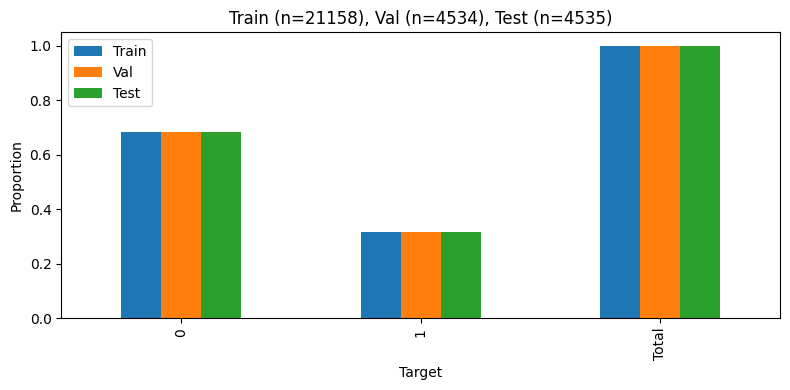

,Train,Val,Test,Train,Val,Test
0,14470,3101,3101,0.683902,0.683944,0.683793
1,6688,1433,1434,0.316098,0.316056,0.316207
Total,21158,4534,4535,1.000000,1.000000,1.000000


In [3]:
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(8, 4))

df_counts = pd.DataFrame({
    "Train": train_df["Target"].value_counts(),
    "Val": val_df["Target"].value_counts(),
    "Test": test_df["Target"].value_counts()
})

df_counts.loc["Total"] = [len(train_df), len(val_df), len(test_df)]

df_percent = df_counts / df_counts.loc["Total"]

df_percent.plot(kind="bar", ax=ax)
ax.set_title(f"Train (n={len(train_df)}), Val (n={len(val_df)}), Test (n={len(test_df)})")
ax.set_xlabel("Target")
ax.set_ylabel("Proportion")
plt.tight_layout()
plt.show()

pd.concat([df_counts, df_percent], axis=1)


## Display Sample DICOM Images with Annotations

Visualizing sample DICOM images with their corresponding annotations is a crucial step in medical imaging machine learning workflows. This visualization serves multiple purposes: it validates our data loading pipeline, confirms the accuracy of bounding box annotations, and provides clinical context for the machine learning task.

DICOM (Digital Imaging and Communications in Medicine) is the standard format for medical imaging, containing both pixel data and rich metadata about the patient, acquisition parameters, and clinical context. Working with these specialized files requires careful handling to ensure proper interpretation of the radiological information.

In this cell:

- We select a diverse sample of 6 DICOM images from our training dataset, including both positive and negative pneumonia cases
- Each image is loaded using the pydicom library, which preserves critical metadata while accessing the underlying pixel arrays
- Images are displayed in grayscale, consistent with radiological practice for chest X-rays
- For positive pneumonia cases, we overlay the ground truth bounding boxes that indicate the affected lung regions
- The visualization is arranged in a grid format with patient IDs as titles for easy reference

This visual inspection helps detect potential issues such as:
- Incorrectly positioned or sized bounding boxes
- Poor image quality or contrast that might affect model performance
- Unusual anatomical presentations that may require special handling
- Confirmation that our data loading pipeline correctly interprets the DICOM format

Understanding these visual patterns is essential not only for technical validation but also for developing intuition about the clinical features that distinguish pneumonia cases from normal chest X-rays.

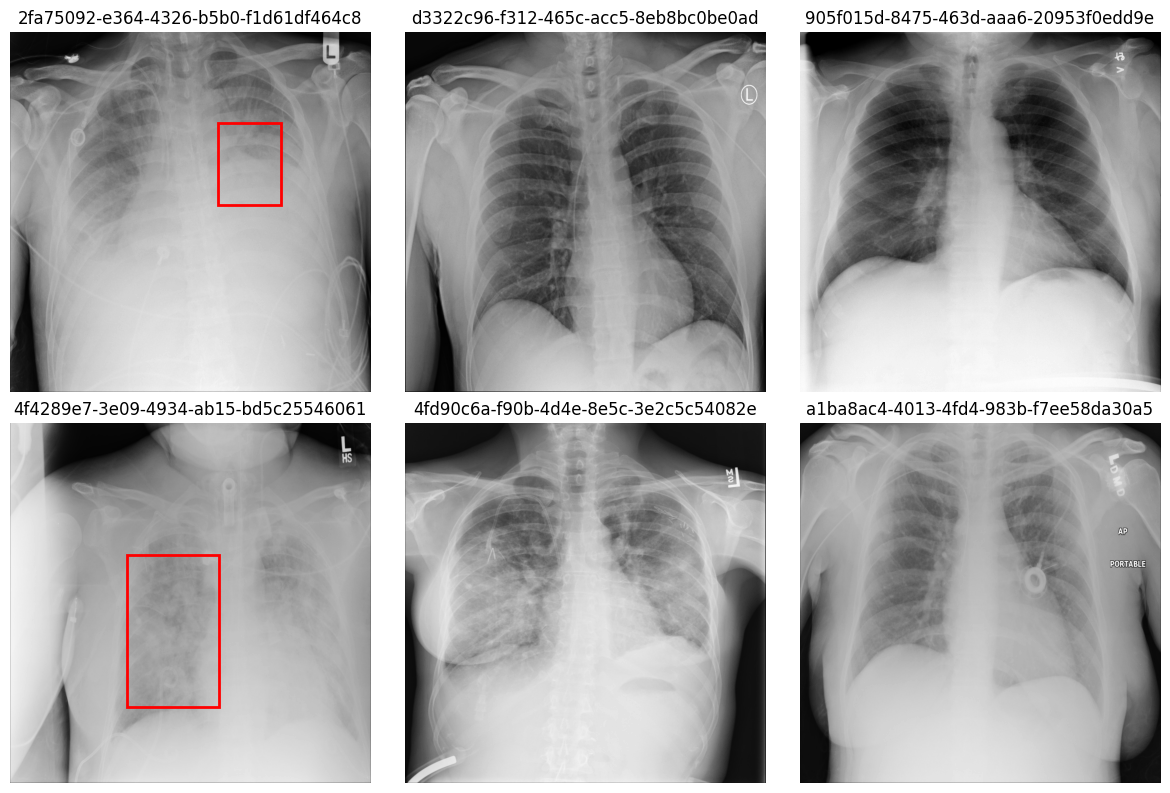

In [4]:
import pydicom

sample = train_df[:6]
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

def draw_bounding_box(ax, x, y, width, height, edgecolor='red'):
    if not any(pd.isnull([x, y, width, height])):
        rect = plt.Rectangle((x, y), width, height, linewidth=2, edgecolor=edgecolor, facecolor='none')
        ax.add_patch(rect)

for ax, (_, row) in zip(axs, sample.iterrows()):
    patient_id = row["patientId"]
    dcm_path = os.path.join(dataset_path, "stage_2_train_images", patient_id + ext)
    ds = pydicom.dcmread(dcm_path)
    ax.imshow(ds.pixel_array, cmap='gray')
    ax.set_title(patient_id)
    ax.axis('off')
    if row["Target"] == 1:
         draw_bounding_box(ax, row["x"], row["y"], row["width"], row["height"])

plt.tight_layout()
plt.show()


## Save Data Splits to CSV Files

This step persists our carefully prepared data splits to disk as CSV files in the `dataset_path` directory, the same location where our original dataset CSV resides. These files will serve as the foundation for our model training pipeline.

Each split (training, validation, and test) is saved as a separate CSV file, preserving all columns from our DataFrames including patient IDs, class labels, and bounding box coordinates. The files maintain the same format as the original CSV, ensuring compatibility with existing data processing workflows. This standardized approach ensures reproducibility and simplifies dataset registration with Azure ML in subsequent steps.

In [5]:
# Write train, val and test DataFrames to CSV files in dataset_path
train_df.to_csv(os.path.join(dataset_path, 'train.csv'), index=False)
val_df.to_csv(os.path.join(dataset_path, 'val.csv'), index=False)
test_df.to_csv(os.path.join(dataset_path, 'test.csv'), index=False)


## Register Data Assets with Azure Machine Learning

This critical step transitions our locally prepared data into a properly registered Azure ML asset, making it accessible for distributed training jobs and ensuring reproducibility across experiments. By registering the dataset, we create a versioned reference that can be tracked, shared, and reused throughout the model development lifecycle.

The registration process involves:

- **Authentication**: Using Azure's DefaultAzureCredential to securely connect to the Azure ML workspace
- **Data asset Definition**: Creating a Data entity with:
  - A descriptive name ("rsna_pneumonia_dataset") for easy identification
  - The path to our prepared dataset folder containing the original images and our custom split CSV files
  - The type specification as "uri_folder" which preserves the directory structure
  - A comprehensive description documenting the dataset's contents and purpose

- **Version Management**: The `create_or_update` method ensures that if a dataset with this name already exists, it will be versioned rather than overwritten

Once registered, this dataset becomes available through the Azure ML Studio interface and can be referenced by name in training scripts and job definitions. This centralized approach eliminates the need to repeatedly transfer large datasets between environments and ensures all team members work with identical data.

In [6]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from workshop_helpers.utils import get_unique_name

credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential)

unique_name = get_unique_name(credential)


Found the config file in: /config.json


Validicating credential....
Credential Validated
Determining unique name....
Unique name: jmerkow


In [7]:
from azure.ai.ml.entities import Data

my_dataset = Data(
    name=f"rsna_pneumonia_dataset-{unique_name}",
    path=dataset_path,
    type="uri_folder",
    description="RSNA Pneumonia detection dataset with custom data splits for train, val and test."
)

registered_dataset = ml_client.data.create_or_update(my_dataset)


Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy '/home/azureuser/data/rsna-pneumonia-detection-challenge' 'https://fmmgmarscollab2208625406.blob.core.windows.net/azureml-blobstore-681e8849-345b-4da8-b1b6-8697ba1ef038/LocalUpload/e41c3f0a32f2821262206fe3d1dae3c5/rsna-pneumonia-detection-challenge' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.


### Alternative Approach: Uploading Data to Blob Storage and Registering it as a Data Asset

While this notebook demonstrates registering data from a local directory, many production ML workflows leverage data already stored in the cloud. Azure Blob Storage provides a scalable, secure foundation for storing and accessing large datasets across distributed training environments. This approach offers several significant advantages:

- **Enterprise Scalability**: Blob Storage can efficiently handle terabytes of imaging data with high throughput access from multiple compute clusters
- **Organizational Collaboration**: Teams can share consistent dataset versions without duplicating large files
- **Cost Efficiency**: Eliminates redundant data transfers between environments and leverages Azure's tiered storage options
- **Integration with Azure Ecosystem**: Seamlessly connects with other Azure services in your ML workflow

This alternative workflow is particularly valuable when:
- Your organization already maintains datasets in Azure Storage
- Multiple teams or projects need access to the same medical imaging collections
- You're working with datasets too large for practical local storage

#### Implementation Steps:

1. **Copy Data to Blob Storage using AzCopy**

   The AzCopy utility provides optimized, resilient transfers between your local environment and Azure Storage. Simply execute:

   ```bash
   azcopy copy "/path/to/local/data" "https://<storage_account>.blob.core.windows.net/<container>?<SAS_token>" --recursive
   ```

2. **Register the Blob Storage Datastore**

   Create a datastore reference that Azure ML can use to securely access your storage account:

   ```python
   from azure.ai.ml.entities import Datastore

   blob_datastore = Datastore(
         name="my_blob_datastore",
         account_name="<storage_account>",
         container_name="<container>",
         account_key="<your_storage_account_key>",  # Or use SAS token for more granular access control
         protocol="https"
   )

   registered_blob_datastore = ml_client.datastores.create_or_update(blob_datastore)
   print(f"Datastore '{registered_blob_datastore.name}' registered.")
   ```

3. **Create a Data Asset from the Registered Datastore Path**

   Finally, define a data asset that references the specific path within your storage where the dataset resides:

   ```python
   from azure.ai.ml.entities import Data

   data_asset = Data(
         name="my_data_asset",
         path="azureml://datastores/my_blob_datastore/paths/path/to/data",
         type="uri_folder",
         description="RSNA Pneumonia detection dataset stored in Azure Blob Storage"
   )

   registered_data_asset = ml_client.data.create_or_update(data_asset)
   print(f"Data asset '{registered_data_asset.name}' created.")
   ```

This approach creates a layer of abstraction between your storage implementation and your ML code, allowing you to change underlying storage details without modifying your training scripts.